In [145]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import cv2

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_similarity_graph_eff_test as sg

In [3]:
# define os - used for making paths
os = 'linux'
# os = 'windows'

In [4]:
# load input data
if os == 'linux':
    data_path = '../../data/original_files/'
elif os == 'windows':
    data_path = '../../data/'

input_data = scipy.io.loadmat(data_path + 'salamanderRGCdata_long_fish_movie.mat')

In [5]:
frames = input_data['frames']
binned_data = input_data['binned_data']

In [ ]:
def show_random_frames(frames, nframes, seed=None):
    assert(len(frames) >= nframes)
    
    if seed is not None:
        np.random.seed(seed)
    
    plt.figure(figsize = (15, nframes))
    
    for i in range(nframes):
        ind = np.random.randint(0,len(frames))
        plt.subplot(-(nframes//-3),3,i+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")
        plt.axis("equal")

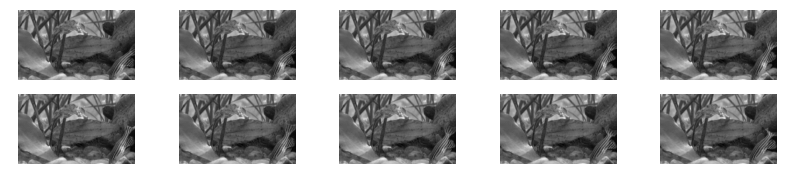

In [69]:
def show_consecutive_frames(frames, st_frame, nframes):
    assert(len(frames) >= nframes)
    
    plt.figure(figsize = (10, nframes//5))
    
    for ind in range(st_frame, st_frame+nframes):
        plt.subplot(-(nframes//-5),5,ind-st_frame+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")
        plt.axis("equal")

show_consecutive_frames(frames, st_frame=100, nframes=10)

In [42]:
# denoise all frames using the bilateral filter
bf_frames = []
for i in range(len(frames)):
    # Apply bilateral filter with d = 15,
    # sigmaColor = sigmaSpace = 75.
    bf_frames = bf_frames + [cv2.bilateralFilter(frames[i], 15, 20, 75)]
bf_frames = np.array(bf_frames)

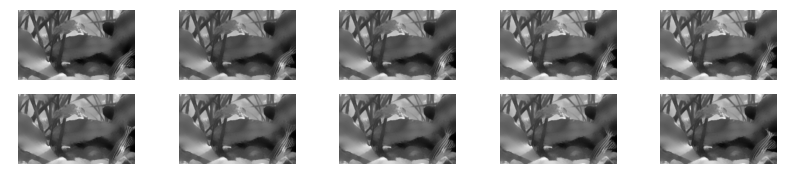

In [70]:
show_consecutive_frames(bf_frames, st_frame=100, nframes=10)

In [59]:
def simple_ft_norm(frames, batch_sz):
    """
    Compute sum of absolute differences between two consecutive frames over a larger set of frames.
    Then, normalize the output matrix.
    
    Inputs: frames, batch_sz
    frames - NxHxW array of N frames of size (H, W)
    batch_sz - size of the set over which absolute differences are summed
    
    Outputs: fvn
    fvn - MxHxW array of normalized differences for M batches (M = N-batch_sz+1)
    """
    
    N, height, width = frames.shape
    M = N - batch_sz + 1
    
    fvs = np.zeros((M, height, width))
    for st_frame in range(M):
        # compute differences between frames
        for i in range(0, batch_sz-1):
            fvs[st_frame] += np.abs(frames[st_frame + i+1] - frames[st_frame + i])

        # normalize
        norm = np.linalg.norm(fvs[st_frame], ord='fro')
        fvs[st_frame] = fvs[st_frame] / (norm + 0.01)
        
    return fvs


In [239]:
def simple_ft_thresh(frames, batch_sz):
    """
    Compute sum of absolute differences between two consecutive frames over a larger set of frames.
    Then, normalize the output matrix.
    
    Inputs: frames, batch_sz
    frames - NxHxW array of N frames of size (H, W)
    batch_sz - size of the set over which absolute differences are summed
    
    Outputs: fvn
    fvn - MxHxW array of normalized differences for M batches (M = N-batch_sz+1)
    """
    
    N, height, width = frames.shape
    M = N - batch_sz + 1
    
    fvs = np.zeros((M, height, width))
    for st_frame in range(M):
        # compute differences between frames
        for i in range(0, batch_sz-1):
            fvs[st_frame] += np.abs(frames[st_frame + i+1] - frames[st_frame + i])

        # normalize
        norm = np.linalg.norm(fvs[st_frame], ord='fro')
        fvs[st_frame] = fvs[st_frame] / (norm + 0.01)
        
        # treshold
        # threshold = (np.max(fvs[st_frame]) - np.min(fvs[st_frame])) / 2
        # threshold = np.median(fvs[st_frame])
        threshold = np.percentile(fvs[st_frame], 50)
        fvs[st_frame] = (fvs[st_frame] > threshold).astype(float)
        
    return fvs

In [225]:
# import matplotlib.animation as manimation

# # Define the meta data for the movie
# FFMpegWriter = manimation.writers['ffmpeg']
# metadata = dict(title='Movie Test', artist='Matplotlib',
#                 comment='a red circle following a blue sine wave')
# writer = FFMpegWriter(fps=15, metadata=metadata)

# # Update the frames for the movie
# fig = plt.figure()
# with writer.saving(fig, "writer_test.mp4", 100):
#     for i in range(500):
#         plt.imshow(bf_fvs[i])
#         writer.grab_frame()

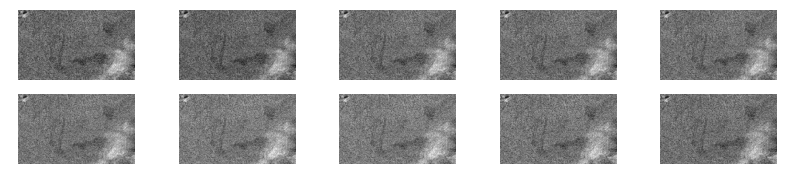

In [73]:
fvs = simple_ft_norm(frames, batch_sz=32)

show_consecutive_frames(fvs, st_frame=100, nframes=10)

In [ ]:
show_random_frames(fvs, nframes=10, seed=0)

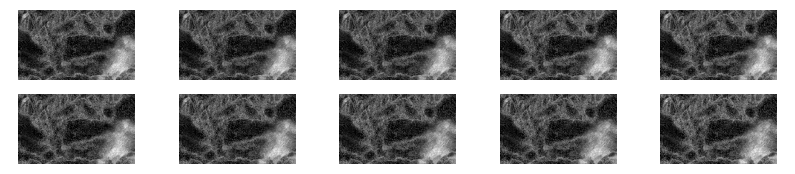

In [82]:
bf_fvs = simple_ft_norm(bf_frames, batch_sz=32)

show_consecutive_frames(bf_fvs, st_frame=100, nframes=10)

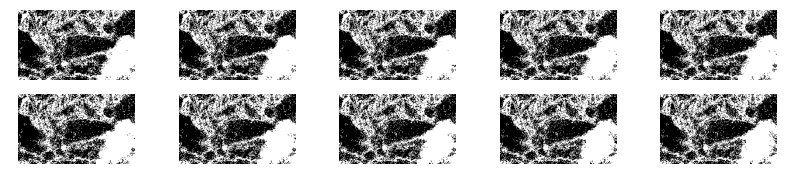

In [249]:
thresh_fvs = simple_ft_thresh(bf_frames, batch_sz=32)

show_consecutive_frames(thresh_fvs, st_frame=100, nframes=10)

# Use Similarity Graph Learning with These Features

In [258]:
# prepare training descriptors
train_dess = bf_fvs[::3,::5,::5].reshape(1110//3, -1)

In [259]:
# prepare training labels
I_order = input_data['I_order'][0]
neuron = I_order[1]
trial = 0

batch_sz = 32
dataset_sz = len(frames)-batch_sz+1

train_lbls = binned_data[trial, :, neuron][batch_sz-1::3]

In [260]:
print('# of training data points: ', len(train_dess))
print('# of features for each data point: ', train_dess.shape[1])
print('Neuron #:', neuron)

num_ones = np.sum(train_lbls == 1)
print('{} (= {:.2f}%) training points belong to class 1.'.format(num_ones, num_ones/len(train_dess)))

# of training data points:  370
# of features for each data point:  960
Neuron #: 35
11 (= 0.03%) training points belong to class 1.


In [261]:
# learning phase
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
              'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'force_all_its': True, 'threshold': 0.01}

B, sg_stats = sg.fit_graph(train_dess, train_lbls, sg_opt_params, mux=1, D=10, seed=0, edgesx=None)

entered sg.fit_graph. Here are the inputs:
dess
 [[0.00325001 0.00215963 0.00650847 ... 0.00865541 0.00541386 0.00758194]
 [0.00324454 0.00216303 0.00757483 ... 0.00865212 0.0054118  0.00865634]
 [0.00216065 0.0032452  0.00756228 ... 0.00972294 0.00756228 0.00863839]
 ...
 [0.0088885  0.00888464 0.00988383 ... 0.00889236 0.01185133 0.01086372]
 [0.00884844 0.00787254 0.00983587 ... 0.00788023 0.01278279 0.01179921]
 [0.00785583 0.00785199 0.01078499 ... 0.00785199 0.01178182 0.01177799]]
lbls
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

<Figure size 640x480 with 0 Axes>

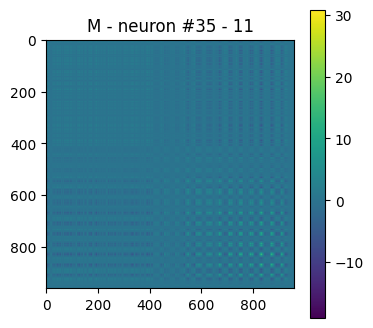

In [266]:
# path to save files
path = 'SimpleFeaturesNorm/'

M = B.T @ B

plt.figure()
sg.display_matrix(M, 'M - neuron #{} - {}'.format(neuron, num_ones))
plt.savefig(path+'Mdiag/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')

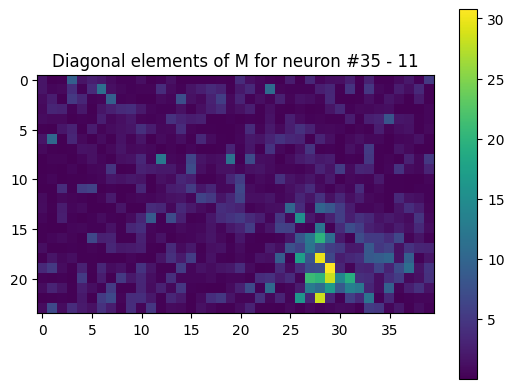

In [267]:
Mdiag = np.array([M[i,i] for i in range(len(M))])

# plot diagonal elements of M in the shape of input images
plt.figure()
plt.imshow(Mdiag.reshape(24,40))
plt.title('Diagonal elements of M for neuron #{} - {}'.format(neuron, num_ones))
plt.colorbar()
plt.savefig(path+'M/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')

# Save diagonal elements of $M^*$ for various neurons

entered sg.fit_graph. Here are the inputs:
dess
 [[0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
lbls
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
opt_params
 {'epsilon0': 1, 'epsilon_d

<Figure size 640x480 with 0 Axes>

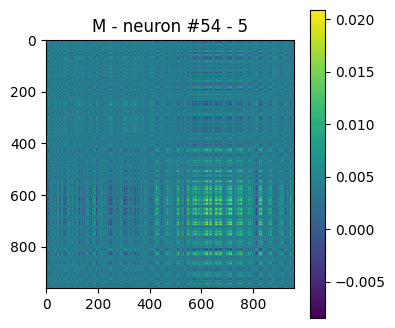

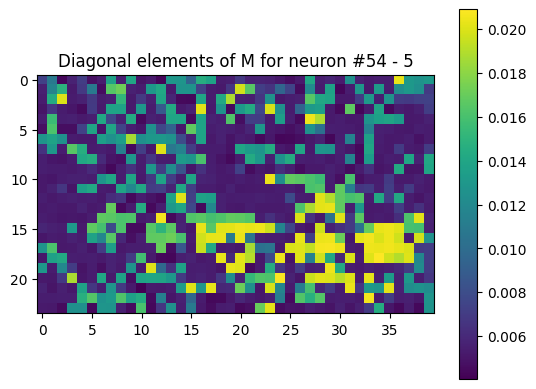

<Figure size 640x480 with 0 Axes>

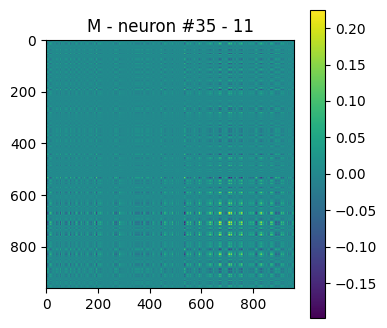

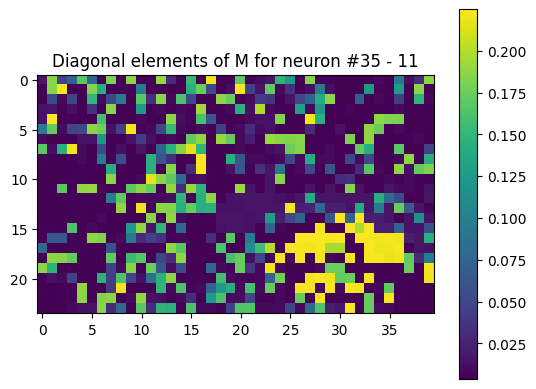

<Figure size 640x480 with 0 Axes>

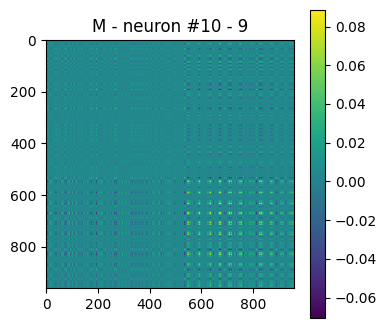

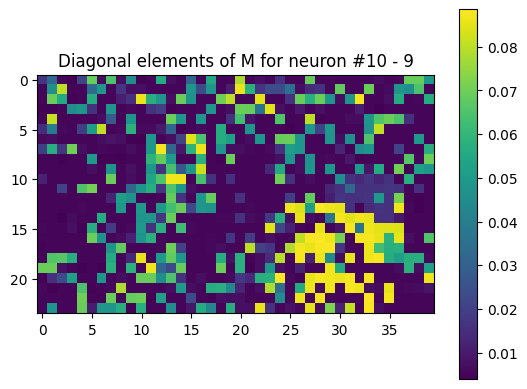

<Figure size 640x480 with 0 Axes>

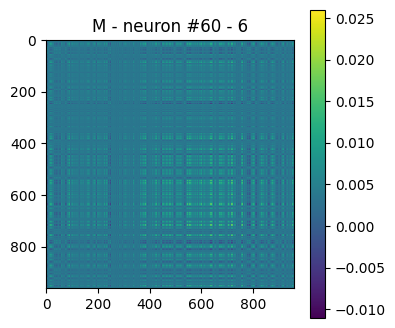

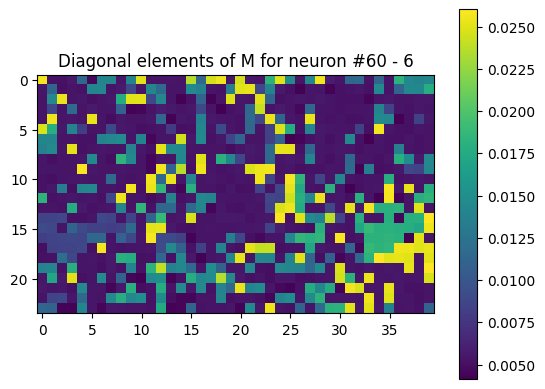

<Figure size 640x480 with 0 Axes>

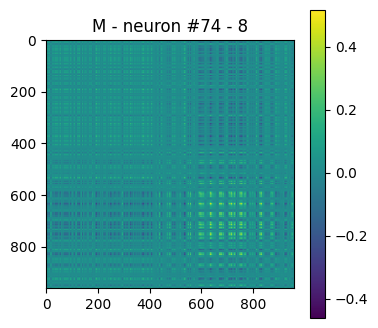

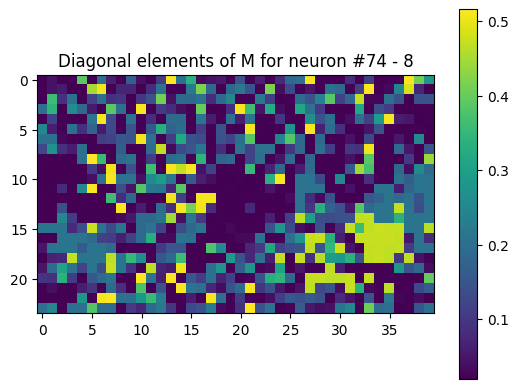

In [257]:
for i in range(11,113):
    neuron = I_order[i]
    train_lbls = binned_data[trial, :, neuron][batch_sz-1::3]
    num_ones = np.sum(train_lbls == 1)
    
    B, sg_stats = sg.fit_graph(train_dess, train_lbls, sg_opt_params, mux=1, D=10, seed=0, edgesx=None)
    
    M = B.T @ B
    plt.figure()
    sg.display_matrix(M, 'M - neuron #{} - {}'.format(neuron, num_ones))
    plt.savefig(path+'Mdiag/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')
    
    Mdiag = np.array([M[i,i] for i in range(len(M))])

    # plot diagonal elements of M in the shape of input images
    plt.figure()
    plt.imshow(Mdiag.reshape(24,40))
    plt.title('Diagonal elements of M for neuron #{} - {}'.format(neuron, num_ones))
    plt.colorbar()
    plt.savefig(path+'M/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')
    